In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import miceforest as mf

In [3]:
df = pd.read_csv("../data/crimes_with_calls_2015_unique_demographics.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'CrimeDate', 'CrimeTime', 'CrimeCode',
       'Location', 'Description', 'Inside/Outside', 'Weapon', 'Post',
       'District', 'Neighborhood', 'Longitude', 'Latitude', 'Location 1',
       'Premise', 'Total Incidents', 'CrimeId', 'callDateTime', 'Priority',
       'CallDescription', 'CallId', 'Year', 'CSA', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'perc_white',
       'median_price_homes_sold', 'racial_diversity_index', 'num_households'],
      dtype='object')

In [5]:
df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1","Location","Location 1"])

Let's do some transformations first, so we don't have to do them twice for the test data.

In [6]:
df['Neighborhood'] = df['Neighborhood'].replace('Patterson Park Neighborho', 'Patterson Park')
df.CrimeDate = pd.to_datetime(df.CrimeDate)
df['Month'] = df.CrimeDate.dt.month
df['CrimeTime'] = [time if time != "24:00:00" else "0:00:00" for time in df['CrimeTime']]
df.CrimeTime = pd.to_datetime(df['CrimeTime'],format= '%H:%M:%S').dt.time
df['crime_hour'] = [int(str(time)[:2]) for time in df.CrimeTime]
df["Year"] = df["CrimeDate"].dt.year
df['Inside/Outside'] = df['Inside/Outside'].str.upper()
df['Inside/Outside'] = df['Inside/Outside'].replace('I', 'INSIDE')
df['Inside/Outside'] = df['Inside/Outside'].replace('O', 'OUTSIDE')
df = pd.get_dummies(df, columns=["Inside/Outside"],drop_first=True)
df = df.rename(columns={"Inside/Outside_OUTSIDE":"Outside"})
df['Weapon'] = df['Weapon'].fillna('NONE')
df = pd.get_dummies(df, columns=["Weapon"])
df['Description'] = df['Description'].replace('RAPE', 'SEXUAL ASSAULT')
date = df.CrimeDate.dt.month*100 + df.CrimeDate.dt.day
df['Season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                       labels=['winter','spring','summer','autumn','winter '])
                  .str.strip()
               )

let's add another column for the call hour


In [7]:
import datetime
df['callDateTime'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in df["callDateTime"]]



In [8]:
df['calltime'] = [datetime.datetime.time(d) for d in df['callDateTime']]

In [9]:
df['calltime'] = [time if time != "24:00:00" else "0:00:00" for time in df['calltime']]
df.callDateTime = pd.to_datetime(df['callDateTime'],format= '%H:%M:%S').dt.time
df['call_hour'] = [int(str(time)[:2]) for time in df.callDateTime]


In [107]:
df["call_hour"].head(10)

0     7
1    18
2     8
3    20
4    12
5    20
6    20
7    22
8    11
9    18
Name: call_hour, dtype: int64

In [108]:
df.columns

Index(['CrimeDate', 'CrimeTime', 'CrimeCode', 'Description', 'Post',
       'District', 'Neighborhood', 'Longitude', 'Latitude', 'Premise',
       'Total Incidents', 'CrimeId', 'callDateTime', 'Priority',
       'CallDescription', 'CallId', 'Year', 'CSA', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'perc_white',
       'median_price_homes_sold', 'racial_diversity_index', 'num_households',
       'Month', 'crime_hour', 'Outside', 'Weapon_FIREARM', 'Weapon_HANDS',
       'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER', 'Season', 'calltime',
       'call_hour'],
      dtype='object')

In [10]:
df = df.drop(columns=["calltime"])

In [11]:
df = pd.get_dummies(df, columns=["Season"])


In [12]:
df = df.drop(columns=["CSA"])


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275 entries, 0 to 9274
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CrimeDate                 9275 non-null   datetime64[ns]
 1   CrimeTime                 9275 non-null   object        
 2   CrimeCode                 9275 non-null   object        
 3   Description               9275 non-null   object        
 4   Post                      9275 non-null   float64       
 5   District                  9275 non-null   object        
 6   Neighborhood              9275 non-null   object        
 7   Longitude                 9275 non-null   float64       
 8   Latitude                  9275 non-null   float64       
 9   Premise                   9188 non-null   object        
 10  Total Incidents           9275 non-null   int64         
 11  CrimeId                   9275 non-null   int64         
 12  callDateTime        

In [113]:
df["CallId"].value_counts()

Series([], Name: CallId, dtype: int64)

drop


In [13]:
df = df.drop(columns=["CallId"])


In [115]:
len(df)

9275

In [14]:
df["Priority"] = df["Priority"].fillna("Unknown")

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275 entries, 0 to 9274
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CrimeDate                 9275 non-null   datetime64[ns]
 1   CrimeTime                 9275 non-null   object        
 2   CrimeCode                 9275 non-null   object        
 3   Description               9275 non-null   object        
 4   Post                      9275 non-null   float64       
 5   District                  9275 non-null   object        
 6   Neighborhood              9275 non-null   object        
 7   Longitude                 9275 non-null   float64       
 8   Latitude                  9275 non-null   float64       
 9   Premise                   9188 non-null   object        
 10  Total Incidents           9275 non-null   int64         
 11  CrimeId                   9275 non-null   int64         
 12  callDateTime        

Drop missing premises


In [15]:
df = df[df["Premise"].notna()]


In [119]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9188 entries, 0 to 9274
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CrimeDate                 9188 non-null   datetime64[ns]
 1   CrimeTime                 9188 non-null   object        
 2   CrimeCode                 9188 non-null   object        
 3   Description               9188 non-null   object        
 4   Post                      9188 non-null   float64       
 5   District                  9188 non-null   object        
 6   Neighborhood              9188 non-null   object        
 7   Longitude                 9188 non-null   float64       
 8   Latitude                  9188 non-null   float64       
 9   Premise                   9188 non-null   object        
 10  Total Incidents           9188 non-null   int64         
 11  CrimeId                   9188 non-null   int64         
 12  callDateTime        

In [16]:
df["CrimeId"].value_counts()


93073     1
115421    1
86279     1
121558    1
89945     1
         ..
130405    1
128356    1
93156     1
108612    1
86014     1
Name: CrimeId, Length: 9188, dtype: int64

In [17]:
df = df.drop(columns=["CrimeId"])


In [18]:
df = df.drop(columns=["CrimeCode", "callDateTime", "Total Incidents"])

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
df.CrimeDate = pd.to_datetime(df.CrimeDate)

# Enter proper date range
dr = pd.date_range(start='2012-01-01', end='2017-09-02')
holidays = calendar.holidays(start=dr.min(), end=dr.max())
df['Holiday'] = df['CrimeDate'].isin(holidays)
df['Holiday'] = df['Holiday'].replace(False, 0)
df['Holiday'] = df['Holiday'].replace(True, 1)

df["Weekday"] = pd.to_datetime(df["CrimeDate"]).dt.dayofweek
df["Weekend"] = (df["Weekday"] > 4).astype(int)
df = df.drop(columns=["Weekday"])

In [124]:
df.columns

Index(['CrimeDate', 'CrimeTime', 'Description', 'Post', 'District',
       'Neighborhood', 'Longitude', 'Latitude', 'Premise', 'Priority',
       'CallDescription', 'Year', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'perc_white',
       'median_price_homes_sold', 'racial_diversity_index', 'num_households',
       'Month', 'crime_hour', 'Outside', 'Weapon_FIREARM', 'Weapon_HANDS',
       'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER', 'call_hour',
       'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter',
       'Holiday', 'Weekend'],
      dtype='object')

In [20]:
df = df.drop(columns=["CrimeDate","CrimeTime"])


In [21]:
df['Premise'] = df['Premise'].str.upper()

# Premise Modifications

df['Premise'] = df['Premise'].replace('GARAGE ON', 'SHED/GARAGE')
df['Premise'] = df['Premise'].replace('APT. LOCKE', 'APARTMENT')
df['Premise'] = df['Premise'].replace('APT/CONDO', 'APARTMENT')
df['Premise'] = df['Premise'].replace('COMMON BUS', 'BUS/AUTO')
df['Premise'] = df['Premise'].replace('HOSP/NURS.', 'HOSPITAL')
df['Premise'] = df['Premise'].replace('VEHICLE', 'BUS/AUTO')
df['Premise'] = df['Premise'].replace('PRIVATE SC', 'SCHOOL')
df['Premise'] = df['Premise'].replace('PUBLIC SCH', 'SCHOOL')
df['Premise'] = df['Premise'].replace('TAVERN/NIG', 'BAR')
df['Premise'] = df['Premise'].replace('RAILROAD C', 'BUS/RAILRO')
df['Premise'] = df['Premise'].replace('COMMON BUS', 'BUS/AUTO')
df['Premise'] = df['Premise'].replace('CHURCH', 'RELIGIOUS')
df['Premise'] = df['Premise'].replace('ARENA', 'STADIUM')
df['Premise'] = df['Premise'].replace('YARD/BUSIN', 'YARD')
df['Premise'] = df['Premise'].replace('PIZZA/OTHE', 'RESTAURANT')
df['Premise'] = df['Premise'].replace('DAY CARE F', 'SCHOOL PLA')
df['Premise'] = df['Premise'].replace('MANUFACTUR', 'WAREHOUSE')
df['Premise'] = df['Premise'].replace('MOBILE HOM', 'DWELLING')
df['Premise'] = df['Premise'].replace('BOX CARS/C', 'BUS/RAILRO')
df['Premise'] = df['Premise'].replace('PHOTO STUD', 'RETAIL/SMA')
df['Premise'] = df['Premise'].replace('TRUCKING &', 'TRACTOR TR')
df['Premise'] = df['Premise'].replace('SKYWALK', 'PUBLIC ARE')
df['Premise'] = df['Premise'].replace('FINANCE/LO', 'BANK/FINAN')
df['Premise'] = df['Premise'].replace('STRUCTURE-', 'UNKNOWN')
df['Premise'] = df['Premise'].replace('BLDG UNDER', 'CONSTRUCTI')
df['Premise'] = df['Premise'].replace('HOUSE UNDE', 'CONSTRUCTI')
df['Premise'] = df['Premise'].replace('MAILBOX-ST', 'STREET')
df['Premise'] = df['Premise'].replace('RENTAL/VID', 'RETAIL/SMA')

In [22]:
df['Neighborhood'] = df['Neighborhood'].str.upper()


In [23]:
df['Priority'] = df['Priority'].str.upper()


In [24]:
df["CallDescription"] = df['CallDescription'].str.upper()

In [132]:
pd.set_option('display.max_rows', 500)

In [25]:
temp = df["CallDescription"].value_counts()


In [26]:
stuff = list(temp.index)

In [27]:
sorted(stuff)

['**POSSIBLE',
 '*5G',
 '*6D',
 '*75',
 '*7C',
 '*ATTEMPT',
 '*ATTEMPTED',
 '*BAILOUT',
 '*BY THREAT',
 '*CHECK WELL BEIN',
 '*CHECK WELLBEING',
 '*CHEK WELL BEING',
 '*CK WELL BEING',
 '*COMMERCIAL',
 '*COMMERCIAL BURG',
 '*DOMESTIC',
 '*FEMALE SCREAMIN',
 '*GET BELONGINGS',
 '*HEALTH CARE FAC',
 '*HOLLERING HELP',
 '*HOME INVASION',
 '*INFOR ONLY',
 '*INVEST',
 '*INVEST TROUBLE',
 '*INVESTIGATE',
 '*NOTIFY',
 '*OUT OF JURIS',
 '*PEACE ORDER',
 '*POLICE ASSIST',
 '*POLICE INFO',
 '*POLICE INFOR',
 '*POLICE INFORMAT',
 '*POSSIBLE',
 '*PROT ORDER',
 '*REAR TAG',
 '*SEE TEXT',
 '*UNKNOWN PROBLEM',
 '*VEH FIRE',
 '*VEHICLE',
 '27',
 '3N',
 '49',
 '4D',
 '56',
 '6D',
 '6J',
 '7C',
 '911/HANGUP',
 '911/NO VOICE',
 'ABDUCTION OTHER',
 'AED NONBREATHIG',
 'AED NONBREATHING',
 'AGGRAV ASSAULT',
 'ANIMAL CRUELTY',
 'ANIMAL DISTURB',
 'ANIMAL IN HARBOR',
 'ARMED PERSON',
 'ASSIST',
 'ASSISTANCE',
 'ATTEMPT',
 'ATTEMPT AUT THFT',
 'ATTEMPTED',
 'ATTEMPTED THEFT',
 'ATTEMTED',
 'ATTMPT BURGLARY',


In [28]:
df = df[df["CallDescription"]!= "`"]

In [29]:
df["CallDescription"] = df["CallDescription"].str.replace("*","")

<ipython-input-29-3747ea68fe77>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["CallDescription"] = df["CallDescription"].str.replace("*","")


In [30]:
temp = df["CallDescription"].value_counts()

In [31]:
stuff = list(temp.index)
sorted(stuff)

['27',
 '3N',
 '49',
 '4D',
 '56',
 '5G',
 '6D',
 '6J',
 '75',
 '7C',
 '911/HANGUP',
 '911/NO VOICE',
 'ABDUCTION OTHER',
 'AED NONBREATHIG',
 'AED NONBREATHING',
 'AGGRAV ASSAULT',
 'ANIMAL CRUELTY',
 'ANIMAL DISTURB',
 'ANIMAL IN HARBOR',
 'ARMED PERSON',
 'ASSIST',
 'ASSISTANCE',
 'ATTEMPT',
 'ATTEMPT AUT THFT',
 'ATTEMPTED',
 'ATTEMPTED THEFT',
 'ATTEMTED',
 'ATTMPT BURGLARY',
 'AUDIBLE ALARM',
 'AUTO ACC/INJURY',
 'AUTO ACCIDENT',
 'AUTO THEFT',
 'BAIL OUT',
 'BAILOUT',
 'BANK CHECK',
 'BIKE LARCENY',
 'BURGLARY',
 'BY THREAT',
 'BY THREATS',
 'CAB HOLDUP',
 'CAR FIRE',
 'CAR JACKING',
 'CHECK WELL BEIN',
 'CHECK WELLBEING',
 'CHECKWELLBEING',
 'CHEK WELL BEING',
 'CHILD REMOVAL',
 'CHK WELL BEING',
 'CK WELL BEING',
 'CK WELL-BEING',
 'COMMERCIAL',
 'COMMERCIAL BURG',
 'COMMON ASSAULT',
 'CURFEW VIOLATION',
 'CUTTING',
 'DEPT ACCIDENT',
 'DESTRUCT PROPTY',
 'DISCHRG FIREARM',
 'DISORDERLY',
 'DISPUTE',
 'DOG BITE',
 'DOMESTIC',
 'EMERG. PETITION',
 'EX PARTE',
 'EXPARTE',
 'FALSE

Lots of spelling mistakes...

In [32]:
df['CallDescription'] = df['CallDescription'].replace('AED NONBREATHIG', 'AED NONBREATHING')
df['CallDescription'] = df['CallDescription'].replace('ASSIST', 'ASSISTANCE')
df['CallDescription'] = df['CallDescription'].replace('ATTEMPT', 'ATTEMPTED')
df['CallDescription'] = df['CallDescription'].replace('ATTEMTED', 'ATTEMPTED')
df['CallDescription'] = df['CallDescription'].replace('ATTMPT BURGLARY', 'ATTEMPTED THEFT')
df['CallDescription'] = df['CallDescription'].replace('BAIL OUT', 'BAILOUT')
df['CallDescription'] = df['CallDescription'].replace('BY THREATS', 'BY THREAT')
df['CallDescription'] = df['CallDescription'].replace('CHECK WELL BEIN', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CHECKWELLBEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CHEK WELL BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CHK WELL BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CK WELL BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CK WELL-BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('WELL BEING CHECK', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('WELLBEING CHECK', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('EXPARTE', 'EX PARTE')
df['CallDescription'] = df['CallDescription'].replace('FOLLOW UP', 'FOLLOW-UP')
df['CallDescription'] = df['CallDescription'].replace('FOOT  PATROL', 'FOOT PATROL')
df['CallDescription'] = df['CallDescription'].replace('GET   BELONGINGS', 'GET BELONGINGS')
df['CallDescription'] = df['CallDescription'].replace('GET BELONINGS', 'GET BELONGINGS')
df['CallDescription'] = df['CallDescription'].replace('INVEST', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVEST TRB', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVEST TROUBLE', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVEST.', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVESTGATE', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVESTIGTE', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVESTIG AUTO', 'INVESTIGATE AUTO')
df['CallDescription'] = df['CallDescription'].replace('LARCENCY', 'LARCENY')
df['CallDescription'] = df['CallDescription'].replace('OUT OF JURIS', 'OUT OF JURISDC')
df['CallDescription'] = df['CallDescription'].replace('POLICE ASSIT', 'POLICE ASSIST')
df['CallDescription'] = df['CallDescription'].replace('POLICE INFOR', 'POLICE INFO')
df['CallDescription'] = df['CallDescription'].replace('POLICE INFORMAT', 'POLICE ASSIST')
df['CallDescription'] = df['CallDescription'].replace('POSS', 'POSSIBLE')
df['CallDescription'] = df['CallDescription'].replace('PROT ORDER', 'PROTECTIVE ORDER')
df['CallDescription'] = df['CallDescription'].replace('PROTECT ORDER', 'PROTECTIVE ORDER')
df['CallDescription'] = df['CallDescription'].replace('SEARCH& SEIZURE', 'SEARCH&SEIZURE')
df['CallDescription'] = df['CallDescription'].replace('UNAUTHOR USE', 'UNAUTHORIZED USE')
df['CallDescription'] = df['CallDescription'].replace('UNKNOWN TROUBLE', 'UNKNOWN PROBLEM')

In [33]:
df['Priority'] = df['Priority'].replace('EMERGENCY', 'HIGH')

In [34]:
df = pd.get_dummies(df, columns=["Priority"])

let's do a stratified split now



In [9]:
from sklearn.model_selection import train_test_split

In [35]:


train , test = train_test_split(df,shuffle=True, stratify=df[["Description"]], random_state=42069, test_size=0.2)

In [36]:
def income_cat_proportions(data):
    return data["Description"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42069)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(test),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [37]:
compare_props


,Overall,Stratified,Random,Rand. %error,Strat. %error
AGG. ASSAULT,0.070317,0.070185,0.076170,8.323760,-0.187392
ARSON,0.004245,0.004353,0.003808,-10.285706,2.530621
ASSAULT BY THREAT,0.013171,0.013058,0.011425,-13.251468,-0.858821
AUTO THEFT,0.135518,0.135473,0.122416,-9.668052,-0.032644
BURGLARY,0.109503,0.109358,0.103373,-5.597427,-0.132015
COMMON ASSAULT,0.138348,0.138194,0.148531,7.360693,-0.111297
HOMICIDE,0.005551,0.005441,0.007617,37.210096,-1.992788
LARCENY,0.237618,0.237758,0.235038,-1.085896,0.058943
LARCENY FROM AUTO,0.188092,0.188248,0.195321,3.843405,0.083059
ROBBERY - CARJACKING,0.003483,0.003264,0.004353,24.959195,-6.280604


In [168]:
train.columns


Index(['Description', 'Post', 'District', 'Neighborhood', 'Longitude',
       'Latitude', 'Premise', 'CallDescription', 'Year',
       'median_household_income', 'households_below_poverty', 'perc18_24',
       'perc25_64', 'perc65up', 'perc_asian', 'perc_aa', 'perc_hisp',
       'perc_white', 'median_price_homes_sold', 'racial_diversity_index',
       'num_households', 'Month', 'crime_hour', 'Outside', 'Weapon_FIREARM',
       'Weapon_HANDS', 'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER',
       'call_hour', 'Season_autumn', 'Season_spring', 'Season_summer',
       'Season_winter', 'Holiday', 'Weekend', 'Priority_HIGH', 'Priority_LOW',
       'Priority_MEDIUM', 'Priority_NON-EMERGENCY', 'Priority_OUT OF SERVICE',
       'Priority_UNKNOWN'],
      dtype='object')

let's label encode Description, District, Neighborhood, Premise, CallDescription

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

Again, let's transform the test data as well so we don't have to do it twice. LabelEncoder has to be called each time. Let's add an unknown label to take care of issues with the test data.

In [40]:
train["Description"] = le.fit_transform(train[train.columns[0]])
Description = dict(zip(le.classes_, le.transform(le.classes_)))


<ipython-input-40-dd8f74988a74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Description"] = le.fit_transform(train[train.columns[0]])


In [41]:
test["Description"] = le.transform(test["Description"])

<ipython-input-41-2490a7a8ba10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Description"] = le.transform(test["Description"])


In [42]:
train["District"] = le.fit_transform(train[train.columns[2]])
District = dict(zip(le.classes_, le.transform(le.classes_)))

<ipython-input-42-da6a39826da7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["District"] = le.fit_transform(train[train.columns[2]])


In [43]:
test["District"] = le.transform(test["District"])

<ipython-input-43-e71555037c98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["District"] = le.transform(test["District"])


In [44]:
train["Neighborhood"] = le.fit_transform(train[train.columns[3]])
Neighborhood = dict(zip(le.classes_, le.transform(le.classes_)))

<ipython-input-44-f75cebfd2a4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Neighborhood"] = le.fit_transform(train[train.columns[3]])


In [45]:
test["Neighborhood"] = le.transform(test["Neighborhood"])


<ipython-input-45-e3ce4ac61923>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Neighborhood"] = le.transform(test["Neighborhood"])


In [46]:
temp = le.fit(train[train.columns[6]])


In [47]:
import bisect
le_classes = le.classes_.tolist()
bisect.insort_left(le_classes, '<unknown>')
le.classes_ = le_classes

In [48]:
le.classes_

['<unknown>',
 'ALLEY',
 'APARTMENT',
 'ATM MACHIN',
 'AUTO PARTS',
 'BANK/FINAN',
 'BAR',
 'BARBER/BEA',
 'BOAT/SHIP',
 'BUS. PARK',
 'BUS/AUTO',
 'BUS/RAILRO',
 'CAR  REPAI',
 'CAR LOT-NE',
 'CARRY OUT',
 'CLOTHING/S',
 'CLUB HOUSE',
 'CONSTRUCTI',
 'CONVENIENC',
 'CONVENTION',
 'COURT HOUS',
 'DEPARTMENT',
 'DOCTORS OF',
 'DRIVEWAY',
 'DRUG STORE',
 'DWELLING',
 'FAST FOOD',
 'FIRE DEPAR',
 'GAS STATIO',
 'GROCERY/CO',
 'HARDWARE/B',
 'HOSPITAL',
 'HOTEL/MOTE',
 'INNER HARB',
 'LAUNDRY/CL',
 'LIBRARY',
 'LIGHT RAIL',
 'LIQUOR STO',
 'MARKET STA',
 'NIGHT DEPO',
 'OFFICE BUI',
 'OTHER - IN',
 'OTHER - OU',
 'OTHER/RESI',
 'PARK',
 'PARKING LO',
 'PAWN SHOP',
 'PLAYGROUND',
 'PORCH/DECK',
 'PUBLIC ARE',
 'PUBLIC BUI',
 'PUBLIC HOU',
 'RACE TRACK',
 'RECREATION',
 'RELIGIOUS',
 'RESTAURANT',
 'RETAIL/SMA',
 'ROW/TOWNHO',
 'SALESMAN/C',
 'SCHOOL',
 'SCHOOL PLA',
 'SHED/GARAG',
 'SHED/GARAGE',
 'SHOPPING M',
 'SINGLE HOU',
 'SPECIALTY',
 'STADIUM',
 'STREET',
 'THEATRE',
 'UNKNOWN',
 'UT

In [49]:
Premise = dict(zip(le.classes_, le.transform(le.classes_)))


In [50]:
train["Premise"] = le.transform(train[train.columns[6]])

<ipython-input-50-1f5d965f6ce4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Premise"] = le.transform(train[train.columns[6]])


In [51]:
test.loc[~test["Premise"].isin(le.classes_),"Premise"] = "<unknown>"

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [52]:
test["Premise"] = le.transform(test["Premise"])

<ipython-input-52-920e440ab0ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Premise"] = le.transform(test["Premise"])


In [53]:
temp = le.fit(train[train.columns[7]])

In [54]:
le_classes = le.classes_.tolist()
bisect.insort_left(le_classes, '<unknown>')
le.classes_ = le_classes

In [55]:
Call_Desc = dict(zip(le.classes_, le.transform(le.classes_)))


In [56]:
train["CallDescription"] = le.transform(train[train.columns[7]])

<ipython-input-56-3846805b1696>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["CallDescription"] = le.transform(train[train.columns[7]])


In [57]:
test.loc[~test["CallDescription"].isin(le.classes_),"CallDescription"] = "<unknown>"

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [58]:
test["CallDescription"] = le.transform(test["CallDescription"])

<ipython-input-58-157e6b88c743>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["CallDescription"] = le.transform(test["CallDescription"])


Finally we can impute

In [59]:
kernel = mf.MultipleImputedKernel(data=train, save_all_iterations=True,random_state=42069)


In [60]:
kernel.mice(5,verbose=True,n_jobs=-1)

Dataset 0
1  | median_household_income | households_below_poverty | perc18_24 | perc25_64 | perc65up | perc_asian | perc_aa | perc_hisp | perc_white | median_price_homes_sold | racial_diversity_index | num_households
2  | median_household_income | households_below_poverty | perc18_24 | perc25_64 | perc65up | perc_asian | perc_aa | perc_hisp | perc_white | median_price_homes_sold | racial_diversity_index | num_households
3  | median_household_income | households_below_poverty | perc18_24 | perc25_64 | perc65up | perc_asian | perc_aa | perc_hisp | perc_white | median_price_homes_sold | racial_diversity_index | num_households
4  | median_household_income | households_below_poverty | perc18_24 | perc25_64 | perc65up | perc_asian | perc_aa | perc_hisp | perc_white | median_price_homes_sold | racial_diversity_index | num_households
5  | median_household_income | households_below_poverty | perc18_24 | perc25_64 | perc65up | perc_asian | perc_aa | perc_hisp | perc_white | median_price_homes_so

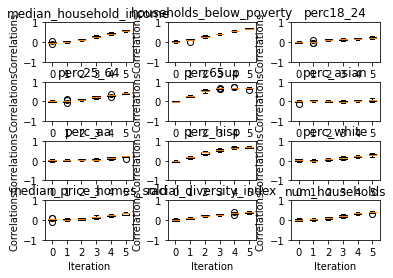

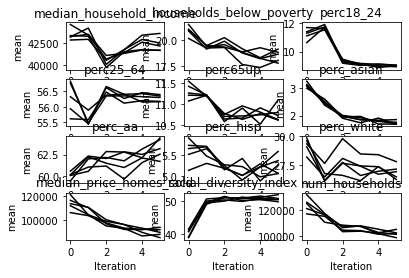

In [248]:
kernel.plot_correlations(wspace=0.4,hspace=0.5)
kernel.plot_mean_convergence()

About the same as in the larger data. At least it's consistent

Let's take the average per neighborhood

In [61]:
df_NA = train[train.isna().any(axis=1)]

In [62]:
missing_neigh = list(df_NA["Neighborhood"].unique())

In [63]:
temp = train.dropna()

In [64]:
temp[temp["Neighborhood"].isin(missing_neigh)]

,Description,Post,District,Neighborhood,Longitude,Latitude,Premise,CallDescription,Year,median_household_income,...,Season_summer,Season_winter,Holiday,Weekend,Priority_HIGH,Priority_LOW,Priority_MEDIUM,Priority_NON-EMERGENCY,Priority_OUT OF SERVICE,Priority_UNKNOWN


In [65]:
missing_neigh


[31,
 48,
 248,
 110,
 188,
 101,
 155,
 165,
 156,
 49,
 185,
 265,
 182,
 228,
 222,
 229,
 137]

In [66]:
completed_data = kernel.complete_data(0)


In [67]:
means = completed_data.groupby("Neighborhood").mean()

In [68]:
means.loc[0] #gives the mean values for Neighborhood 0

Description                      7.000000
Post                           513.000000
District                         3.000000
Longitude                      -76.611147
Latitude                        39.325675
Premise                         57.923077
CallDescription                 66.923077
Year                          2015.000000
median_household_income      32241.138221
households_below_poverty        23.847087
perc18_24                       30.297173
perc25_64                       52.065716
perc65up                         7.079005
perc_asian                      13.862044
perc_aa                         32.036724
perc_hisp                        5.200532
perc_white                      44.485383
median_price_homes_sold     167000.000000
racial_diversity_index          67.515185
num_households              170000.000000
Month                            5.923077
crime_hour                      17.923077
Outside                          0.923077
Weapon_FIREARM                   0

In [69]:
means_1 = means[["median_household_income","households_below_poverty","perc18_24","perc25_64","perc65up","perc_asian","perc_aa","perc_hisp","perc_white","median_price_homes_sold","racial_diversity_index","num_households"]]

In [70]:
means_1.loc[missing_neigh]

,median_household_income,households_below_poverty,perc18_24,perc25_64,perc65up,perc_asian,perc_aa,perc_hisp,perc_white,median_price_homes_sold,racial_diversity_index,num_households
Neighborhood,,,,,,,,,,,,
31,38275.264981,21.466483,9.684237,54.769230,10.485668,1.635046,63.212835,7.892944,27.454851,87819.736842,56.416779,94350.000000
48,44102.318987,14.570103,8.956599,56.460933,11.856502,1.719332,68.558091,3.805212,21.195789,94189.075630,44.661339,108068.739496
248,39159.000600,24.033555,9.024927,55.597806,10.239969,1.726552,67.280798,5.066093,23.252498,62907.142857,47.040323,80566.190476
110,42269.424527,16.340106,8.856210,55.015705,12.698926,1.617462,71.417897,4.349768,19.534278,91129.411765,43.686194,105947.058824
188,42618.042417,20.789362,9.322343,56.225559,9.951727,1.593463,55.554186,9.060029,36.953675,107865.116279,62.018112,111563.953488
101,53064.021380,11.577135,8.478103,58.071892,11.421826,1.754725,60.355161,3.157008,29.019614,103807.222222,53.445817,117514.444444
155,38380.777827,21.783262,8.929459,54.720432,11.338161,1.295277,75.136248,4.907984,16.863099,64342.105263,44.118403,81644.736842
165,43097.798955,18.017305,8.572686,55.649709,11.559736,1.931758,57.182917,7.377819,34.116784,98808.333333,55.845333,108158.333333
156,43907.487626,14.699578,8.603376,56.851117,11.665733,1.650353,71.401408,3.763275,20.465509,87558.333333,46.497019,105725.000000


In [71]:
missing_means = means_1.loc[missing_neigh]


In [72]:
for i in missing_neigh:
    completed_data.loc[completed_data["Neighborhood"]==i,"median_household_income"] = missing_means["median_household_income"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"households_below_poverty"] = missing_means["households_below_poverty"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc18_24"] = missing_means["perc18_24"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc25_64"] = missing_means["perc25_64"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc65up"] = missing_means["perc65up"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc_asian"] = missing_means["perc_asian"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc_aa"] = missing_means["perc_aa"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc_hisp"] = missing_means["perc_hisp"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"perc_white"] = missing_means["perc_white"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"median_price_homes_sold"] = missing_means["median_price_homes_sold"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"racial_diversity_index"] = missing_means["racial_diversity_index"].loc[i]
    completed_data.loc[completed_data["Neighborhood"]==i,"num_households"] = missing_means["num_households"].loc[i]


In [74]:
completed_data.to_csv("../data/TRAIN_911_DEMO_MERGED_ENCODED.CSV",index=False)

# RUN FROM HERE IF MODEL FILE CORRUPT AGAIN

In [4]:
completed_data = pd.read_csv("../data/TRAIN_911_DEMO_MERGED_ENCODED.CSV")

In [5]:
X = completed_data.drop(columns=["Description"])
y = completed_data["Description"]

In [263]:
X.columns

Index(['Post', 'District', 'Neighborhood', 'Longitude', 'Latitude', 'Premise',
       'CallDescription', 'Year', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'perc_white',
       'median_price_homes_sold', 'racial_diversity_index', 'num_households',
       'Month', 'crime_hour', 'Outside', 'Weapon_FIREARM', 'Weapon_HANDS',
       'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER', 'call_hour',
       'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter',
       'Holiday', 'Weekend', 'Priority_HIGH', 'Priority_LOW',
       'Priority_MEDIUM', 'Priority_NON-EMERGENCY', 'Priority_OUT OF SERVICE',
       'Priority_UNKNOWN'],
      dtype='object')

In [6]:
X = X.drop(columns=["Post","District","Longitude", "Latitude", "Year", "Season_autumn", "Season_spring", "Season_winter", "Season_summer"])

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2,random_state=42069)


Finally we can train a bloody model. Let's just do lightGBM. Running out of time. This is due very soon.

In [1]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from IPython.display import Image


In [267]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -6, 7),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,40,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15,
    "boosting": hp.choice("boosting",["gbdt", "dart", "goss"]),
    "class_weight": hp.choice("class_weight",["balanced",None])
}

In [268]:
def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier()
        booster.set_params(**params)
        booster.fit(X,y)

        mlflow.log_params(params)

        score = cross_val_score(booster, X, y, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': booster.get_params()}

In [269]:
with mlflow.start_run(run_name='lightgbm_911_1'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


[LightGBM] [Warning]                                  
boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
100%|██████████| 50/50 [02:10<00:00,  2.62s/trial, best loss: -0.5611587738965664]


Oops. Let's redo that with the proper X and y, and use the validation sets for early stopping.



In [282]:
def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier(**params, n_jobs=-1, silent=True, objective = "multiclass",random_state=42069,
                    num_class=15)
        booster.fit(X_train,y_train,eval_metric="auc_mu", eval_set=[(X_valid, y_valid)], early_stopping_rounds=15)

        mlflow.log_params(params)

        score = cross_val_score(booster, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': booster.get_params()}

In [283]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -6, 7),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,40,1)),
    "boosting": hp.choice("boosting",["gbdt", "dart", "goss"]),
    "class_weight": hp.choice("class_weight",["balanced",None])
}

In [284]:
with mlflow.start_run(run_name='lightgbm_911_3'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )

[1]	valid_0's auc_mu: 0.926991	valid_0's multi_logloss: 1.88533
[2]	valid_0's auc_mu: 0.943708	valid_0's multi_logloss: 1.61635
[3]	valid_0's auc_mu: 0.955199	valid_0's multi_logloss: 1.43055
[4]	valid_0's auc_mu: 0.957861	valid_0's multi_logloss: 1.29258
[5]	valid_0's auc_mu: 0.959629	valid_0's multi_logloss: 1.1879
[6]	valid_0's auc_mu: 0.96096	valid_0's multi_logloss: 1.10469
[7]	valid_0's auc_mu: 0.961682	valid_0's multi_logloss: 1.03526
[8]	valid_0's auc_mu: 0.960316	valid_0's multi_logloss: 1.16761
[9]	valid_0's auc_mu: 0.959665	valid_0's multi_logloss: 1.08371
[10]	valid_0's auc_mu: 0.959054	valid_0's multi_logloss: 1.09283
[11]	valid_0's auc_mu: 0.959362	valid_0's multi_logloss: 1.02356
[12]	valid_0's auc_mu: 0.959878	valid_0's multi_logloss: 0.967742
[13]	valid_0's auc_mu: 0.959567	valid_0's multi_logloss: 0.979862
[14]	valid_0's auc_mu: 0.958976	valid_0's multi_logloss: 0.974474
[15]	valid_0's auc_mu: 0.959576	valid_0's multi_logloss: 0.927644
[16]	valid_0's auc_mu: 0.961401	

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matr

Oh god. Let's turn that validation verbose off.

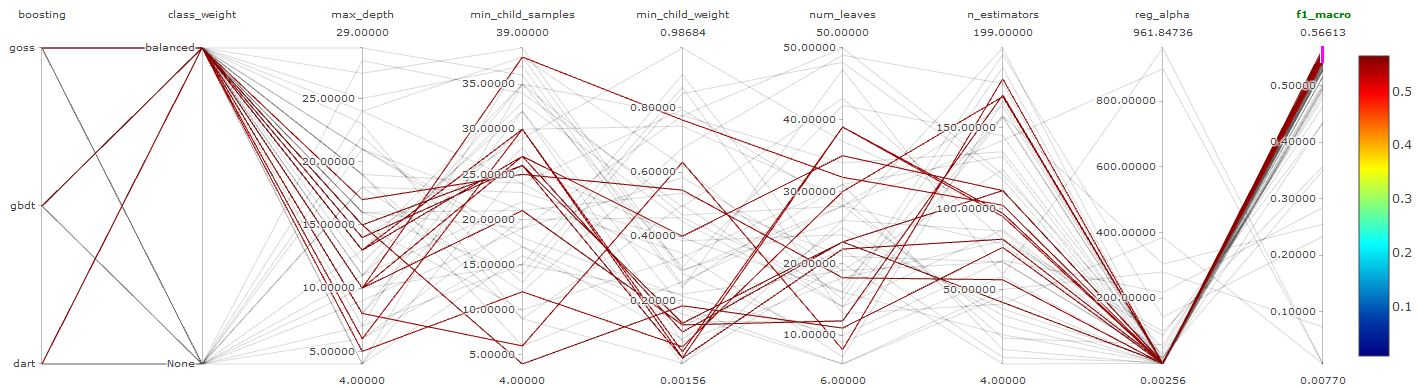

In [286]:
Image(filename='../images/911_1.JPG')


In [287]:
check = lgb.LGBMClassifier(class_weight="balanced", max_depth=15,min_child_samples=26,
            min_child_weight=0.12852574086802737, n_jobs=-1, silent=True, objective = "multiclass",random_state=42069,
                    num_class=15, n_estimators=42, num_leaves=23, reg_alpha=2.2856428322539624)


In [288]:
check.fit(X_train,y_train,eval_metric="auc_mu", eval_set=[(X_valid, y_valid)], early_stopping_rounds=15, verbose=False)

LGBMClassifier(class_weight='balanced', max_depth=15, min_child_samples=26,
               min_child_weight=0.12852574086802737, n_estimators=42,
               num_class=15, num_leaves=23, objective='multiclass',
               random_state=42069, reg_alpha=2.2856428322539624)

In [289]:
score = cross_val_score(check, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

In [290]:
np.mean(score)

0.5661264148243174

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

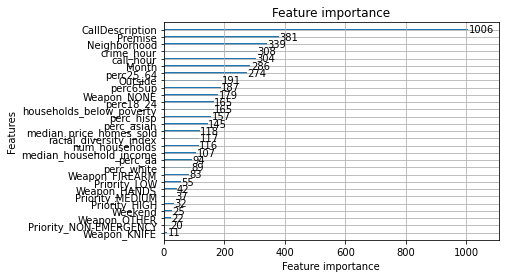

In [291]:
lgb.plot_importance(check)

Looks like everything is pretty important. Won't bother dropping anything in the interest of time, but can experiment with this later


In [294]:
def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier(**params, n_jobs=-1, silent=True, objective = "multiclass",random_state=42069,
                    num_class=15)
        booster.fit(X_train,y_train,eval_metric="auc_mu", eval_set=[(X_valid, y_valid)], early_stopping_rounds=15,
                    verbose=False)

        mlflow.log_params(params)

        score = cross_val_score(booster, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': booster.get_params()}


In [293]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -10, 2.5),
    'min_child_weight': hp.loguniform('min_child_weight', -10, 2.5),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',2,40,1)),
    "boosting": hp.choice("boosting",["gbdt", "dart", "goss"]),
    "class_weight": "balanced"
}


In [295]:
with mlflow.start_run(run_name='lightgbm_911_4'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 50/50 [01:48<00:00,  2.17s/trial, best loss: -0.5731472535021153]


c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')

c:\users\administrator\documents\github\dazed-confusion-matr

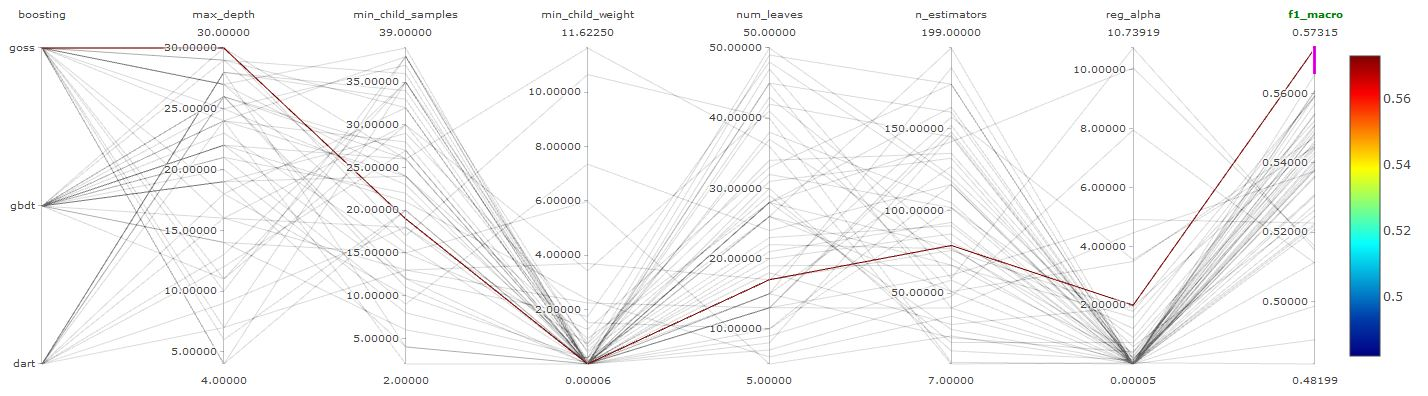

In [297]:
Image(filename='../images/911_2.JPG')

Niiiiice. One more run to see if we can beat that one.

In [302]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 29, 50,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 30,1)),
    'reg_alpha': hp.loguniform('reg_l1', -10, 1.5),
    'min_child_weight': hp.loguniform('min_child_weight', -10, 0.5),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',2,40,1)),
    "boosting": "goss",
    "class_weight": "balanced"
}

In [303]:
with mlflow.start_run(run_name='lightgbm_911_7'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )

100%|██████████| 100/100 [02:38<00:00,  1.58s/trial, best loss: -0.5691289961032521]


Damn. Alright the earlier one wins.


In [11]:
MODEL = lgb.LGBMClassifier(boosting_type="goss",n_jobs=-1, silent=True,
                    objective = "multiclass",random_state=42069, class_weight="balanced", max_depth=30,
                    num_class=15, min_child_samples=19, min_child_weight=0.00020106166502972648,
                    n_estimators=79, num_leaves=17, reg_alpha=1.998033356098756)

In [12]:
MODEL.fit(X_train,y_train,eval_metric="auc_mu", eval_set=[(X_valid, y_valid)], early_stopping_rounds=15,
                    verbose=False)


LGBMClassifier(boosting_type='goss', class_weight='balanced', max_depth=30,
               min_child_samples=19, min_child_weight=0.00020106166502972648,
               n_estimators=79, num_class=15, num_leaves=17,
               objective='multiclass', random_state=42069,
               reg_alpha=1.998033356098756)

In [307]:
score = cross_val_score(MODEL, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
np.mean(score)


0.5731472535021153

In [13]:
MODEL.booster_.save_model("911_model.txt")

# Now let's check the test data


Impute


In [75]:
completed_test = kernel.impute_new_data(new_data=test)


In [76]:
completed_data_test = completed_test.complete_data(0)

In [77]:

df_NA_test = test[test.isna().any(axis=1)]

In [78]:
missing_neigh_test = list(df_NA_test["Neighborhood"].unique())

In [79]:
temp = test.dropna()

In [80]:
temp[temp["Neighborhood"].isin(missing_neigh_test)]


,Description,Post,District,Neighborhood,Longitude,Latitude,Premise,CallDescription,Year,median_household_income,...,Season_summer,Season_winter,Holiday,Weekend,Priority_HIGH,Priority_LOW,Priority_MEDIUM,Priority_NON-EMERGENCY,Priority_OUT OF SERVICE,Priority_UNKNOWN


In [81]:
means = completed_data_test.groupby("Neighborhood").mean()

In [82]:
means_1 = means[["median_household_income","households_below_poverty","perc18_24","perc25_64","perc65up","perc_asian","perc_aa","perc_hisp","perc_white","median_price_homes_sold","racial_diversity_index","num_households"]]

In [83]:
missing_means = means_1.loc[missing_neigh_test]


In [84]:
for i in missing_neigh_test:
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"median_household_income"] = missing_means["median_household_income"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"households_below_poverty"] = missing_means["households_below_poverty"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc18_24"] = missing_means["perc18_24"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc25_64"] = missing_means["perc25_64"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc65up"] = missing_means["perc65up"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc_asian"] = missing_means["perc_asian"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc_aa"] = missing_means["perc_aa"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc_hisp"] = missing_means["perc_hisp"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"perc_white"] = missing_means["perc_white"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"median_price_homes_sold"] = missing_means["median_price_homes_sold"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"racial_diversity_index"] = missing_means["racial_diversity_index"].loc[i]
    completed_data_test.loc[completed_data_test["Neighborhood"]==i,"num_households"] = missing_means["num_households"].loc[i]

In [86]:
completed_data_test.to_csv("../data/TEST_911_DEMO_MERGED_ENCODED.CSV", index=False)

In [342]:
X_final_test = completed_data_test.drop(columns=["Description"])
y_final_test = completed_data_test["Description"]

In [343]:
X_final_test.columns

Index(['Post', 'District', 'Neighborhood', 'Longitude', 'Latitude', 'Premise',
       'CallDescription', 'Year', 'median_household_income',
       'households_below_poverty', 'perc18_24', 'perc25_64', 'perc65up',
       'perc_asian', 'perc_aa', 'perc_hisp', 'perc_white',
       'median_price_homes_sold', 'racial_diversity_index', 'num_households',
       'Month', 'crime_hour', 'Outside', 'Weapon_FIREARM', 'Weapon_HANDS',
       'Weapon_KNIFE', 'Weapon_NONE', 'Weapon_OTHER', 'call_hour',
       'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter',
       'Holiday', 'Weekend', 'Priority_HIGH', 'Priority_LOW',
       'Priority_MEDIUM', 'Priority_NON-EMERGENCY', 'Priority_OUT OF SERVICE',
       'Priority_UNKNOWN'],
      dtype='object')

In [344]:
X_final_test = X_final_test.drop(columns=["Post","District","Longitude", "Latitude", "Year", "Season_autumn", "Season_spring", "Season_winter", "Season_summer"])

In [345]:
predictions = MODEL.predict(X_final_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

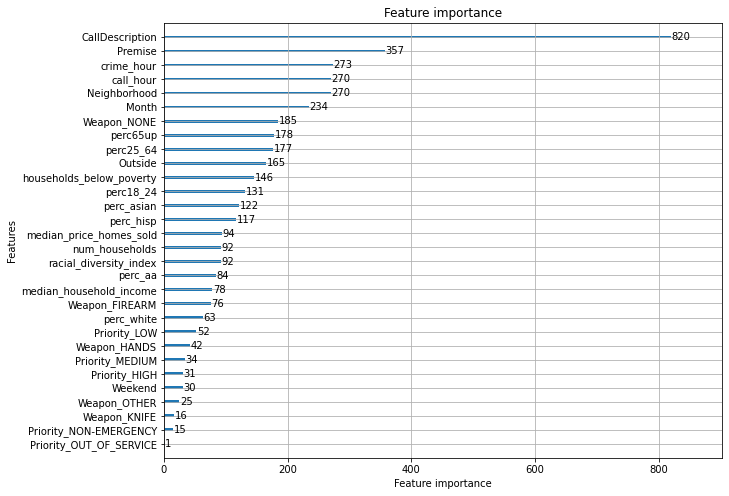

In [347]:
lgb.plot_importance(MODEL, figsize=(10,8))

In [348]:
from sklearn import metrics

In [349]:
metrics.accuracy_score(predictions,y_final_test)

0.7720348204570185

In [350]:
metrics.recall_score(predictions,y_final_test,average="weighted",zero_division=0)

0.7720348204570185

In [351]:
metrics.precision_score(predictions,y_final_test,average="weighted",zero_division=0)

0.7850126869124439

In [352]:
metrics.f1_score(predictions,y_final_test,average="weighted",zero_division=0)

0.7679508258568465

In [87]:
with open('../data/911_Premise_decoder.csv', 'w') as f:
    for key in Premise.keys():
        f.write("%s,%s\n"%(key,Premise[key]))

In [88]:
with open('../data/911_Neighborhood_decoder.csv', 'w') as f:
    for key in Neighborhood.keys():
        f.write("%s,%s\n"%(key,Neighborhood[key]))

In [89]:
with open('../data/911_District_decoder.csv', 'w') as f:
    for key in District.keys():
        f.write("%s,%s\n"%(key,District[key]))

In [90]:
with open('../data/911_Description_decoder.csv', 'w') as f:
    for key in Description.keys():
        f.write("%s,%s\n"%(key,Description[key]))


In [92]:
with open('../data/911_Call_Description_decoder.csv', 'w') as f:
    for key in Call_Desc.keys():
        f.write("%s,%s\n"%(key,Call_Desc[key]))